In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

In [2]:
train_ = pd.read_csv('dataset/train.csv')
test_ = pd.read_csv('dataset/test.csv')

train_.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [3]:
# 편한 가독성을 위해 연, 월, 일을 분리

def split_date(df):
    y = []
    m = []
    d = []
    
    for i in df['Date']:
        d_, m_, y_ = i.split('/')
        y.append(int(y_))
        m.append(int(m_))
        d.append(int(d_))
        
    df.insert(3, 'Y', y)
    df.insert(4, 'M', m)
    df.insert(5, 'D', d)
    
    return df

# holiday이면 1, 아니면 0

def holiday(df):
    tmp = []
    
    for i in df['IsHoliday']:
        if i == False:
            tmp.append(0)
        else:
            tmp.append(1)
            
    df.insert(15, 'Holiday', tmp)
    
    return df

In [4]:
train_ = split_date(train_)
train_ = holiday(train_)

train_ = train_.fillna(0)

test_ = split_date(test_)
test_ = holiday(test_)

test_ = test_.fillna(0)

train_.head()

,id,Store,Date,Y,M,D,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Holiday,Weekly_Sales
0,1,1,05/02/2010,2010,2,5,42.31,2.572,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1643690.90
1,2,1,12/02/2010,2010,2,12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,8.106,True,1,1641957.44
2,3,1,19/02/2010,2010,2,19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1611968.17
3,4,1,26/02/2010,2010,2,26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1409727.59
4,5,1,05/03/2010,2010,3,5,46.50,2.625,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1554806.68


In [5]:
test_.head()

,id,Store,Date,Y,M,D,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Holiday
0,1,1,05/10/2012,2012,10,5,68.55,3.617,8077.89,0.00,18.22,3617.43,3626.14,6.573,False,0
1,2,1,12/10/2012,2012,10,12,62.99,3.601,2086.18,0.00,8.11,602.36,5926.45,6.573,False,0
2,3,1,19/10/2012,2012,10,19,67.97,3.594,950.33,0.00,4.93,80.25,2312.85,6.573,False,0
3,4,1,26/10/2012,2012,10,26,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,False,0
4,5,2,05/10/2012,2012,10,5,70.27,3.617,6037.76,0.00,10.04,3027.37,3853.40,6.170,False,0


## KNR + Robust

In [6]:
# Promotion들에서 이상치가 너무 많다고 판단, 적절한 scaling 방식을 취할 필요가 있음
# Robust, Standard를 실행해 볼 계획

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

In [7]:
# Robust부터 실행

scaler = RobustScaler()

features = train_.iloc[:, 8:13]
colnames = features.columns + ['_Scaled']

features_scaled = pd.DataFrame(scaler.fit_transform(features), columns = colnames)

train_robust = pd.concat([train_, features_scaled], axis = 1)
train_robust.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'id', 'Date', 'IsHoliday'], axis = 1, inplace = True)
train_robust

,Store,Y,M,D,Temperature,Fuel_Price,Unemployment,Holiday,Weekly_Sales,Promotion1_Scaled,Promotion2_Scaled,Promotion3_Scaled,Promotion4_Scaled,Promotion5_Scaled
0,1,2010,2,5,42.31,2.572,8.106,0,1643690.90,0.000000,0.0,0.000000,0.000000,0.000000
1,1,2010,2,12,38.51,2.548,8.106,1,1641957.44,0.000000,0.0,0.000000,0.000000,0.000000
2,1,2010,2,19,39.93,2.514,8.106,0,1611968.17,0.000000,0.0,0.000000,0.000000,0.000000
3,1,2010,2,26,46.63,2.561,8.106,0,1409727.59,0.000000,0.0,0.000000,0.000000,0.000000
4,1,2010,3,5,46.50,2.625,8.106,0,1554806.68,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,45,2012,8,31,75.09,3.867,8.684,0,734297.87,12.335020,60.0,33.248658,36.566951,2.226726
6251,45,2012,9,7,75.70,3.911,8.684,1,766512.66,5.752087,128.0,18.830054,9.705248,1.146626
6252,45,2012,9,14,67.87,3.948,8.684,0,702238.27,5.952181,0.0,1.538462,17.904453,2.938893
6253,45,2012,9,21,65.32,4.038,8.684,0,723086.20,4.409997,922.8,22.626118,12.434619,4.836166


In [8]:
features = test_.iloc[:, 8:13]
colnames = features.columns + ['_Scaled']

features_scaled = pd.DataFrame(scaler.fit_transform(features), columns = colnames)

test_robust = pd.concat([test_, features_scaled], axis = 1)
test_robust.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'id', 'Date', 'IsHoliday'], axis = 1, inplace = True)
test_robust

,Store,Y,M,D,Temperature,Fuel_Price,Unemployment,Holiday,Promotion1_Scaled,Promotion2_Scaled,Promotion3_Scaled,Promotion4_Scaled,Promotion5_Scaled
0,1,2012,10,5,68.55,3.617,6.573,0,1.392288,0.00,0.456136,2.640406,0.259693
1,1,2012,10,12,62.99,3.601,6.573,0,-0.062816,0.00,0.002468,0.065965,0.987452
2,1,2012,10,19,67.97,3.594,6.573,0,-0.338661,0.00,-0.140229,-0.379843,-0.155799
3,1,2012,10,26,69.16,3.506,6.573,0,0.058530,31.75,-0.092214,0.454299,-0.474653
4,2,2012,10,5,70.27,3.617,6.170,0,0.896837,0.00,0.089073,2.136579,0.331592
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,44,2012,10,26,46.97,3.755,5.217,0,-0.560065,2.61,-0.317478,-0.448365,-0.742708
176,45,2012,10,5,64.89,3.985,8.667,0,0.656164,0.00,0.483060,1.475744,-0.147206
177,45,2012,10,12,54.47,4.000,8.667,0,-0.094363,0.00,-0.007404,0.063369,0.374980
178,45,2012,10,19,56.47,3.969,8.667,0,-0.082769,0.00,-0.218757,-0.074606,-0.401103


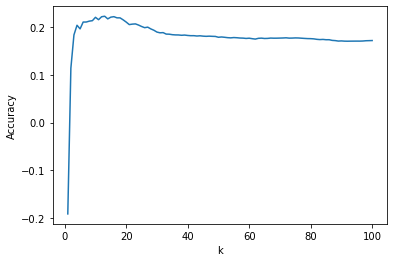

In [9]:
X = train_robust.drop('Weekly_Sales', axis = 1)
Y = train_robust['Weekly_Sales']

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 908)

k_list = range(1,101)
accuracies = []

for k in k_list:
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(train_x, train_y)
    accuracies.append(model.score(test_x, test_y))
      
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Accuracy")

plt.show()

In [10]:
model = KNeighborsRegressor(n_neighbors = accuracies.index(max(accuracies)) + 1)
model.fit(X, Y)

y = model.predict(test_robust)
y

array([1239231.35923077, 1294977.93692308, 1406797.35461538,
        994479.95538462, 1282135.14307692, 1386667.14      ,
       1294816.16923077,  783495.15615385, 1344560.85615385,
       1317202.22      ,  924071.29923077,  955873.37230769,
       1175307.20307692, 1163206.35230769, 1315968.63307692,
       1089985.40615385, 1196498.42461538, 1032756.62846154,
       1054074.83      ,  991866.36769231, 1248360.86538462,
        850538.55538462,  999936.80230769, 1023324.46846154,
       1139485.74769231,  996716.93076923, 1296342.50615385,
       1007252.64384615,  968458.13692308, 1240266.87076923,
       1046039.30923077,  834648.05923077, 1131817.29923077,
       1148098.00384615,  943115.70769231, 1161065.98307692,
       1246140.23      , 1406184.14461538, 1232904.63461538,
       1354274.84615385, 1227032.17384615, 1244751.09615385,
       1350545.25307692,  906410.67538462, 1651257.55538462,
       1563074.72461538, 1425895.97615385,  820696.71153846,
       1191810.50076923,

In [11]:
df_robust = pd.DataFrame({'id' : list(range(1, len(y) + 1)), 'Weekly_Sales' : y})
df_robust.set_index('id', inplace = True)
df_robust

,Weekly_Sales
id,
1,1.239231e+06
2,1.294978e+06
3,1.406797e+06
4,9.944800e+05
5,1.282135e+06
...,...
176,7.814161e+05
177,5.936018e+05
178,6.424473e+05


In [12]:
df_robust.to_csv('./result/KNR_Robust.csv', encoding = 'utf-8-sig')

## KNR + Robust + 가중평균

In [13]:
# Robust부터 실행

scaler = RobustScaler()

features = train_.iloc[:, 8:13]
colnames = features.columns + ['_Scaled']

features_scaled = pd.DataFrame(scaler.fit_transform(features), columns = colnames)

train_robust = pd.concat([train_, features_scaled], axis = 1)
train_robust.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'id', 'Date', 'IsHoliday'], axis = 1, inplace = True)

features = test_.iloc[:, 8:13]
colnames = features.columns + ['_Scaled']

features_scaled = pd.DataFrame(scaler.fit_transform(features), columns = colnames)

test_robust = pd.concat([test_, features_scaled], axis = 1)
test_robust.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'id', 'Date', 'IsHoliday'], axis = 1, inplace = True)

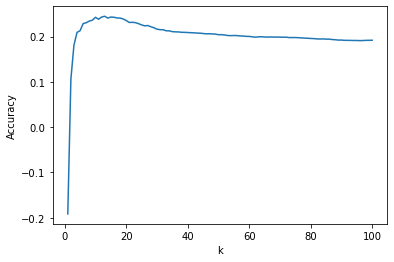

In [14]:
X = train_robust.drop('Weekly_Sales', axis = 1)
Y = train_robust['Weekly_Sales']

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 908)

k_list = range(1,101)
accuracies = []

for k in k_list:
    model = KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    model.fit(train_x, train_y)
    accuracies.append(model.score(test_x, test_y))
      
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Accuracy")

plt.show()

In [15]:
model = KNeighborsRegressor(n_neighbors = accuracies.index(max(accuracies)) + 1, weights = 'distance')
model.fit(X, Y)

y = model.predict(test_robust)
y

array([1293338.90662545, 1306484.27257028, 1368044.9202845 ,
       1018777.65097729, 1309744.56357442, 1381074.8156413 ,
       1257771.15495668,  739808.57100153, 1294724.65455858,
       1284070.05145707,  952917.77897148,  967338.56473707,
       1176847.48207872, 1177101.96618107, 1384801.45599197,
       1132044.62359682, 1139693.35344592, 1050754.97337647,
       1034861.68011954,  981344.08918384, 1206216.6523226 ,
        878227.41246691,  997419.93344363,  968108.35255066,
       1093941.59294641,  991657.0674943 , 1220340.29154073,
        940050.56742715,  987924.99182339, 1193505.01869062,
       1023182.71789041,  811463.49587276, 1127618.27484616,
       1105816.83858796,  922387.51582911, 1154488.70502378,
       1243433.32303231, 1379286.78189704, 1224031.73566477,
       1246587.91845425, 1241301.68866409, 1246552.1024826 ,
       1341117.33609793,  915368.0374894 , 1658782.16398894,
       1566301.98985675, 1450341.30943679,  799094.46683056,
       1228646.33888358,

In [16]:
df_robust = pd.DataFrame({'id' : list(range(1, len(y) + 1)), 'Weekly_Sales' : y})
df_robust.set_index('id', inplace = True)
df_robust

,Weekly_Sales
id,
1,1.293339e+06
2,1.306484e+06
3,1.368045e+06
4,1.018778e+06
5,1.309745e+06
...,...
176,7.615983e+05
177,5.734669e+05
178,6.207628e+05


In [17]:
df_robust.to_csv('./result/KNR_Distance_Robust.csv', encoding = 'utf-8-sig')

## KNR + Standard

In [18]:
# Standard도 실행

scaler = StandardScaler()

features = train_.iloc[:, 8:13]
colnames = features.columns + ['_Scaled']

features_scaled = pd.DataFrame(scaler.fit_transform(features), columns = colnames)

train_standard = pd.concat([train_, features_scaled], axis = 1)
train_standard.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'id', 'Date', 'IsHoliday'], axis = 1, inplace = True)

features = test_.iloc[:, 8:13]
colnames = features.columns + ['_Scaled']

features_scaled = pd.DataFrame(scaler.fit_transform(features), columns = colnames)

test_standard = pd.concat([test_, features_scaled], axis = 1)
test_standard.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'id', 'Date', 'IsHoliday'], axis = 1, inplace = True)

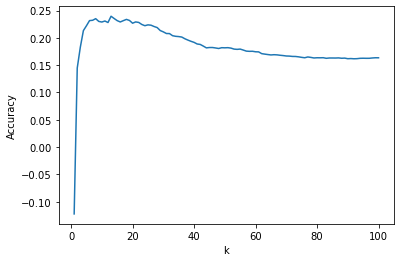

In [19]:
X = train_standard.drop('Weekly_Sales', axis = 1)
Y = train_standard['Weekly_Sales']

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 908)

k_list = range(1,101)
accuracies = []

for k in k_list:
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(train_x, train_y)
    accuracies.append(model.score(test_x, test_y))
      
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Accuracy")

plt.show()

In [20]:
model = KNeighborsRegressor(n_neighbors = accuracies.index(max(accuracies)) + 1)
model.fit(X, Y)

y = model.predict(test_robust)
y

array([1494234.61923077, 1308023.97846154, 1390067.61076923,
       1363906.75384615, 1397237.79538462, 1319893.69153846,
       1341332.64076923, 1633372.19384615, 1344560.85615385,
       1317202.22      ,  951976.44692308, 1121499.63384615,
       1176720.35769231, 1086162.24923077, 1453943.43615385,
       1633372.19384615, 1196498.42461538, 1053306.41230769,
        945949.63846154, 1119977.57153846, 1165482.23846154,
        978580.31230769,  976107.5       , 1773217.96076923,
       1013478.71461538,  990484.52461538, 1328341.09538462,
       1549964.22461538,  990326.99769231, 1144892.83538462,
        897863.03461538, 1015859.24846154, 1171444.05      ,
       1109389.68769231,  835880.54692308, 1012455.38076923,
       1582042.02461538, 1233156.84307692, 1123569.73923077,
       1696300.41923077, 1235643.11461538, 1094023.87692308,
       1422675.88384615, 1622121.25384615, 1674979.29384615,
       1394759.29769231, 1434307.23461538, 1642397.29307692,
       1406479.74692308,

In [21]:
df_standard = pd.DataFrame({'id' : list(range(1, len(y) + 1)), 'Weekly_Sales' : y})
df_standard.set_index('id', inplace = True)
df_standard

,Weekly_Sales
id,
1,1.494235e+06
2,1.308024e+06
3,1.390068e+06
4,1.363907e+06
5,1.397238e+06
...,...
176,8.759235e+05
177,6.181055e+05
178,6.025471e+05


In [22]:
df_standard.to_csv('./result/KNR_Standard.csv', encoding = 'utf-8-sig')

## KNR + Standard + 가중평균

In [23]:
# Standard도 실행

scaler = StandardScaler()

features = train_.iloc[:, 8:13]
colnames = features.columns + ['_Scaled']

features_scaled = pd.DataFrame(scaler.fit_transform(features), columns = colnames)

train_standard = pd.concat([train_, features_scaled], axis = 1)
train_standard.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'id', 'Date', 'IsHoliday'], axis = 1, inplace = True)

features = test_.iloc[:, 8:13]
colnames = features.columns + ['_Scaled']

features_scaled = pd.DataFrame(scaler.fit_transform(features), columns = colnames)

test_standard = pd.concat([test_, features_scaled], axis = 1)
test_standard.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'id', 'Date', 'IsHoliday'], axis = 1, inplace = True)

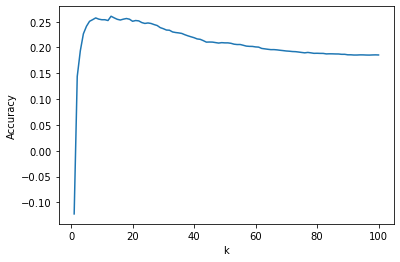

In [24]:
X = train_standard.drop('Weekly_Sales', axis = 1)
Y = train_standard['Weekly_Sales']

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 908)

k_list = range(1,101)
accuracies = []

for k in k_list:
    model = KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    model.fit(train_x, train_y)
    accuracies.append(model.score(test_x, test_y))
      
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Accuracy")

plt.show()

In [25]:
model = KNeighborsRegressor(n_neighbors = accuracies.index(max(accuracies)) + 1, weights = 'distance')
model.fit(X, Y)

y = model.predict(test_robust)
y

array([1508099.4309735 , 1259963.44597984, 1360337.30322734,
       1382912.26474913, 1404528.90205283, 1278122.94484993,
       1324040.08563543, 1640951.25704312, 1293805.54902282,
       1283438.47189632,  942836.32115505, 1122476.05330154,
       1176049.77360833, 1074352.31072495, 1424073.12653214,
       1644865.43797876, 1142375.48200308, 1069412.12468203,
        940802.96035085, 1105410.61594024, 1137867.33805453,
       1003317.20522402,  966467.59727644, 1771060.60520094,
        990070.37027287, 1002750.38137973, 1232321.06263983,
       1623541.59886044,  993781.8066552 , 1087155.56350454,
        894049.31792502, 1040050.23335812, 1156438.26967152,
       1046474.74296459,  825032.27077075, 1015264.07805222,
       1589409.00171398, 1231087.31070297, 1122343.34658592,
       1701468.02329211, 1263846.3754973 , 1131148.12649355,
       1422891.16517743, 1628651.87639192, 1682944.2719721 ,
       1406728.27810648, 1445647.34740626, 1650557.21783341,
       1405637.88844815,

In [26]:
df_standard = pd.DataFrame({'id' : list(range(1, len(y) + 1)), 'Weekly_Sales' : y})
df_standard.set_index('id', inplace = True)
df_standard

,Weekly_Sales
id,
1,1.508099e+06
2,1.259963e+06
3,1.360337e+06
4,1.382912e+06
5,1.404529e+06
...,...
176,8.295906e+05
177,6.078687e+05
178,5.918410e+05


In [27]:
df_standard.to_csv('./result/KNR_Distance_Standard.csv', encoding = 'utf-8-sig')